In [1]:
import os
import numpy as np
import pandas as pd
import xgboost
import xgboost as xgb
import optuna
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error 
import json


import joblib

logical_cores = os.cpu_count()
print(f"Number of logical CPU cores: {logical_cores}")

num_workers = max(1, logical_cores // 2)
print(f"Number of workers set to: {num_workers}")

def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

gpu_available = is_gpu_available()
print(f"GPU available: {gpu_available}")

print(xgboost.build_info())

Number of logical CPU cores: 16
Number of workers set to: 8
GPU available: True
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 4], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 3, 2], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'C:\\Users\\ng_mi\\Anaconda\\envs\\pytorch-gpu\\Lib\\site-packages\\xgboost\\lib\\xgboost.dll'}


In [2]:
os.makedirs('../feature-importances/xbclassifier', exist_ok=True)
os.makedirs('../feature-importances/xbregressor', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbregressor', exist_ok=True)


path = '../data/train'

ticker_list = []

if os.path.exists(path):
    ticker_list = [os.path.splitext(f)[0] for f in os.listdir(path) if f.endswith('.csv')]


In [3]:
def load_or_create_ticker_df(csv_file_path):
    """
    Load the existing ticker DataFrame from a CSV file if it exists,
    otherwise create a new DataFrame with predefined column types.
    Ensure the DataFrame has the specified columns, add any missing columns,
    and rearrange the columns in alphabetical order, excluding 'Ticker_Symbol'.

    Args:
    csv_file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded or newly created DataFrame.
    """
    # Define the column types
    column_types = {
        "Ticker_Symbol": str,
        "Best_Cov1D_Classification_Accuracy": float,
        "Best_Cov1D_Classification_Path": str,
        "Best_Cov1D_Regression_RMSE": float,
        "Best_Cov1D_Regression_Path": str,
        "Best_LSTM_Classification_Accuracy": float,
        "Best_LSTM_Classification_Path": str,
        "Best_LSTM_Regression_RMSE": float,
        "Best_LSTM_Regression_Path": str,
        "Best_Transformer_Classification_Accuracy": float,
        "Best_Transformer_Classification_Path": str,
        "Best_Transformer_Regression_RMSE": float,
        "Best_Transformer_Regression_Path": str,
        "Best_XGBClassifier_Classification_Accuracy": float,
        "Best_XGBClassifier_Classification_Path": str,
        "Best_XGBRegressor_Regression_RMSE": float,
        "Best_XGBRegressor_Regression_Path": str
    }


    if os.path.isfile(csv_file_path):
        # Load the existing file into a DataFrame
        ticker_df = pd.read_csv(csv_file_path)
        
        # Ensure all specified columns are present
        for column, dtype in column_types.items():
            if column not in ticker_df.columns:
                ticker_df[column] = pd.Series(dtype=dtype)
        
        # Reorder columns alphabetically, excluding 'Ticker_Symbol'
        columns = ["Ticker_Symbol"] + sorted([col for col in ticker_df.columns if col != "Ticker_Symbol"])
        ticker_df = ticker_df[columns]
    else:
        # Create a new DataFrame with the specified column types
        ticker_df = pd.DataFrame(columns=column_types.keys()).astype(column_types)
    
    return ticker_df

In [4]:
def delete_hyperparameter_search_model(ticker_symbol, model_type):
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    xbclassifier_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    xbregressor_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    xbclassifier_params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    xbregressor_params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'

    if model_type == "xbclassifier":
        if os.path.isfile(xbclassifier_model_path):
            os.remove(xbclassifier_model_path)
            print(f"Deleted {xbclassifier_model_path}")
        if os.path.isfile(xbclassifier_params_path):
            os.remove(xbclassifier_params_path)
            print(f"Deleted {xbclassifier_params_path}")
    
    if model_type == "xbregressor":
        if os.path.isfile(xbregressor_model_path):
            os.remove(xbregressor_model_path)
            print(f"Deleted {xbregressor_model_path}")
        if os.path.isfile(xbregressor_params_path):
            os.remove(xbregressor_params_path)
            print(f"Deleted {xbregressor_params_path}")

    if os.path.isfile(csv_path):
        ticker_df = pd.read_csv(csv_path)
        if ticker_symbol in ticker_df['Ticker_Symbol'].values:
            if model_type == "xbclassifier":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [pd.NA, pd.NA]
            if model_type == "xbregressor":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [pd.NA, pd.NA]
            ticker_df.to_csv(csv_path, index=False)
            print(f"Deleted {ticker_symbol} from {csv_path}")
        else:
            print(f"{ticker_symbol} not found in {csv_path}")
    else:
        print(f"{csv_path} does not exist")


In [5]:
def training_preprocess_data(df):
    if df.isna().sum().sum() > 0 or df.isin([float('inf'), float('-inf')]).sum().sum() > 0:
        df = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

    df = df.dropna()

    columns_to_drop = [
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ]
    X = df.drop(columns=columns_to_drop)

    # Define the list of specific columns to keep
    columns_to_keep = [
        'RSI', 'EMA', 'ADX', 'PATTERN_SUM'
    ]
    
    # Select only the specified columns
    #X = df[columns_to_keep]
    
    y_classifier = (np.sign(df['DAILY_MIDPRICE_CHANGE']) >= 0).astype(int)
    y_regressor = df['DAILY_MIDPRICE_CHANGE']

    return X, y_classifier, y_regressor

In [6]:
def xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")
    
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'use_label_encoder': False,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        model = XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, preds)
        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBClassifier_Classification_Accuracy'].values[0]
        if pd.isnull(current_score) or study.best_value > current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")
            
             # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model accuracy: {current_score} is better for {ticker_symbol} than accuracy: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [study.best_value], 'Best_XGBClassifier_Classification_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"Parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")

    if hyperparameter_search:
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)

    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    # Split the data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBClassifier(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy for {ticker_symbol}: {accuracy:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [accuracy, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [accuracy], 'Best_XGBClassifier_Classification_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with accuracy: {accuracy:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)
  
    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [7]:
def xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")
        
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        rmse = root_mean_squared_error (y_valid, preds)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params.update(study.best_trial.params)

    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBRegressor_Regression_RMSE'].values[0]
        if pd.isnull(current_score) or study.best_value < current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")

            # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model MSE: {current_score} is better for {ticker_symbol} than MSE: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [study.best_value], 'Best_XGBRegressor_Regression_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")

    if hyperparameter_search:
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        
    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    # Split the data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBRegressor(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    rmse = root_mean_squared_error (y_valid, preds)
    
    print(f"Validation RSME for {ticker_symbol}: {rmse:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [rmse, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [rmse], 'Best_XGBRegressor_Regression_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with RSME: {rmse:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)

    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [8]:
for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/train/{ticker_symbol}.csv")
    X, y_classifier, y_regressor = training_preprocess_data(dataframe)
    xbclassifier_resume_training(X, y_classifier, gpu_available, ticker_symbol, True, True)
    xbregressor_resume_training(X, y_regressor, gpu_available, ticker_symbol, True, True)


[I 2024-09-09 20:47:24,854] A new study created in memory with name: no-name-7a95d4b5-5cac-456b-aef1-b768fde9d8f9


Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:47:25,148] Trial 0 finished with value: 0.7464788732394366 and parameters: {'n_estimators': 992, 'max_depth': 8, 'learning_rate': 0.17481386105003122, 'subsample': 0.6929917807958694, 'colsample_bytree': 0.575730812600933, 'gamma': 3.7113934322124025, 'lambda': 1.0022756031835045e-08, 'alpha': 0.001047802010569917}. Best is trial 0 with value: 0.7464788732394366.
[I 2024-09-09 20:47:25,419] Trial 1 finished with value: 0.7887323943661971 and parameters: {'n_estimators': 980, 'max_depth': 7, 'learning_rate': 0.12024396129744527, 'subsample': 0.6289252955432911, 'colsample_bytree': 0.7835004832588008, 'gamma': 4.106182201251744, 'lambda': 0.4684536824086034, 'alpha': 0.07008560266618576}. Best is trial 1 with value: 0.7887323943661971.
[I 2024-09-09 20:47:25,754] Trial 2 finished with value: 0.7605633802816901 and parameters: {'n_estimators': 550, 'max_depth': 4, 'learning_rate': 0.06064426656922141, 'subsample': 0.9335440532649955, 'colsample_bytree': 0.8437079180410452

Model for CL=F saved with accuracy: 0.8309859154929577
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-09 20:48:11,605] A new study created in memory with name: no-name-3d434d27-de8d-42ec-a11d-93316e64c764


Validation accuracy for CL=F: 0.8310
Model for CL=F saved with accuracy: 0.8310
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:48:11,828] Trial 0 finished with value: 1.0618076220620716 and parameters: {'n_estimators': 413, 'max_depth': 7, 'learning_rate': 0.24247770321085166, 'subsample': 0.8919078575910651, 'colsample_bytree': 0.7366965416850666, 'gamma': 4.92754449449676, 'lambda': 1.2316886067766115e-08, 'alpha': 0.00015546882561638672}. Best is trial 0 with value: 1.0618076220620716.
[I 2024-09-09 20:48:12,081] Trial 1 finished with value: 1.006131723483956 and parameters: {'n_estimators': 937, 'max_depth': 4, 'learning_rate': 0.20067563905683292, 'subsample': 0.69987503774886, 'colsample_bytree': 0.7982840875717703, 'gamma': 0.946764777505652, 'lambda': 0.0011298547219565649, 'alpha': 5.030452421303848e-07}. Best is trial 1 with value: 1.006131723483956.
[I 2024-09-09 20:48:12,265] Trial 2 finished with value: 1.0854569752237901 and parameters: {'n_estimators': 733, 'max_depth': 4, 'learning_rate': 0.28896650682099223, 'subsample': 0.6637844169517815, 'colsample_bytree': 0.67819399561092

Best model for CL=F saved with RMSE: 0.9239946966798451
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.
Validation RSME for CL=F: 0.9240


[I 2024-09-09 20:48:43,039] A new study created in memory with name: no-name-fc3b0cbb-14d3-470c-ad62-25934fc91684


Model for CL=F saved with RSME: 0.9240
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:48:43,529] Trial 0 finished with value: 0.6714285714285714 and parameters: {'n_estimators': 460, 'max_depth': 8, 'learning_rate': 0.03795483805639671, 'subsample': 0.833328419617384, 'colsample_bytree': 0.9582630047736755, 'gamma': 1.6448311765070427, 'lambda': 2.5001725424963163e-06, 'alpha': 0.0002620013895218366}. Best is trial 0 with value: 0.6714285714285714.
[I 2024-09-09 20:48:43,772] Trial 1 finished with value: 0.7285714285714285 and parameters: {'n_estimators': 544, 'max_depth': 10, 'learning_rate': 0.06117573206447856, 'subsample': 0.9603493280011904, 'colsample_bytree': 0.5970482506193872, 'gamma': 2.1292025400093486, 'lambda': 3.704024457122029e-05, 'alpha': 0.7521190975802963}. Best is trial 1 with value: 0.7285714285714285.
[I 2024-09-09 20:48:44,252] Trial 2 finished with value: 0.6857142857142857 and parameters: {'n_estimators': 595, 'max_depth': 4, 'learning_rate': 0.010490706449353546, 'subsample': 0.8734474856815935, 'colsample_bytree': 0.6869288627

Model for NVDA saved with accuracy: 0.7714285714285715
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.
Validation accuracy for NVDA: 0.7714
Model for NVDA saved with accuracy: 0.7714
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json


[I 2024-09-09 20:49:12,981] A new study created in memory with name: no-name-8defd430-c9ea-47e6-adcf-964705566085
[I 2024-09-09 20:49:13,164] Trial 0 finished with value: 1.8454543239928538 and parameters: {'n_estimators': 624, 'max_depth': 9, 'learning_rate': 0.2812187490101949, 'subsample': 0.5155160986591258, 'colsample_bytree': 0.6086625544037347, 'gamma': 3.591843349966537, 'lambda': 0.019779217019670677, 'alpha': 6.896142494867917e-06}. Best is trial 0 with value: 1.8454543239928538.


Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:49:13,357] Trial 1 finished with value: 1.724644883425002 and parameters: {'n_estimators': 782, 'max_depth': 7, 'learning_rate': 0.19323261763925448, 'subsample': 0.9587820808850951, 'colsample_bytree': 0.8369830049753723, 'gamma': 0.8676946732175134, 'lambda': 1.2740655770737014e-06, 'alpha': 3.1174124684080635e-08}. Best is trial 1 with value: 1.724644883425002.
[I 2024-09-09 20:49:13,511] Trial 2 finished with value: 1.7305849700614202 and parameters: {'n_estimators': 498, 'max_depth': 6, 'learning_rate': 0.15362272120410758, 'subsample': 0.7159599390379501, 'colsample_bytree': 0.7788037586143497, 'gamma': 4.34888502729879, 'lambda': 1.1210326144958602e-05, 'alpha': 0.0014256204730778942}. Best is trial 1 with value: 1.724644883425002.
[I 2024-09-09 20:49:13,717] Trial 3 finished with value: 1.7573737898351998 and parameters: {'n_estimators': 131, 'max_depth': 10, 'learning_rate': 0.27531056348495003, 'subsample': 0.7360992801177542, 'colsample_bytree': 0.5814225091

Best model for NVDA saved with RMSE: 1.6707068633106548
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-09 20:49:41,344] A new study created in memory with name: no-name-10b60aa1-89eb-40d6-8c4e-480dc5269ae1


Validation RSME for NVDA: 1.6707
Model for NVDA saved with RSME: 1.6707
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:49:41,523] Trial 0 finished with value: 0.581081081081081 and parameters: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.27208968905163033, 'subsample': 0.746321513764998, 'colsample_bytree': 0.9808190715314573, 'gamma': 4.598367907628725, 'lambda': 6.637834618846638e-05, 'alpha': 0.0242137310432771}. Best is trial 0 with value: 0.581081081081081.
[I 2024-09-09 20:49:41,726] Trial 1 finished with value: 0.5135135135135135 and parameters: {'n_estimators': 594, 'max_depth': 6, 'learning_rate': 0.24579071187394377, 'subsample': 0.8223412837327646, 'colsample_bytree': 0.628712876783293, 'gamma': 2.7627359518178785, 'lambda': 2.1760022477842583e-06, 'alpha': 0.03835367356942006}. Best is trial 0 with value: 0.581081081081081.
[I 2024-09-09 20:49:41,997] Trial 2 finished with value: 0.5405405405405406 and parameters: {'n_estimators': 777, 'max_depth': 8, 'learning_rate': 0.2421099356275541, 'subsample': 0.5745027170415427, 'colsample_bytree': 0.683774170147667, 'ga

Model for SGDUSD=X saved with accuracy: 0.6486486486486487
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.
Validation accuracy for SGDUSD=X: 0.6486
Model for SGDUSD=X saved with accuracy: 0.6486
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json


[I 2024-09-09 20:50:05,721] A new study created in memory with name: no-name-1785af32-c052-41fb-9910-f57c9ad8b0e4
[I 2024-09-09 20:50:05,888] Trial 0 finished with value: 0.0015999310072217926 and parameters: {'n_estimators': 489, 'max_depth': 8, 'learning_rate': 0.21319676722822925, 'subsample': 0.5443781171044748, 'colsample_bytree': 0.9103285403537323, 'gamma': 2.0174430814918214, 'lambda': 2.4419462299745632e-05, 'alpha': 5.546404607441784e-05}. Best is trial 0 with value: 0.0015999310072217926.


Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:50:06,062] Trial 1 finished with value: 0.0016006126171423769 and parameters: {'n_estimators': 581, 'max_depth': 8, 'learning_rate': 0.20494150813235143, 'subsample': 0.5890361395064714, 'colsample_bytree': 0.5888852814805445, 'gamma': 3.2828859773071155, 'lambda': 6.269931708076497e-08, 'alpha': 0.0020798113077597096}. Best is trial 0 with value: 0.0015999310072217926.
[I 2024-09-09 20:50:06,217] Trial 2 finished with value: 0.001606899056173751 and parameters: {'n_estimators': 333, 'max_depth': 8, 'learning_rate': 0.23179599428734987, 'subsample': 0.5220018903085639, 'colsample_bytree': 0.5629647748812023, 'gamma': 4.243915299348824, 'lambda': 0.09118811660226853, 'alpha': 0.6412986980503819}. Best is trial 0 with value: 0.0015999310072217926.
[I 2024-09-09 20:50:06,430] Trial 3 finished with value: 0.0016061122112553926 and parameters: {'n_estimators': 944, 'max_depth': 7, 'learning_rate': 0.07070323975233947, 'subsample': 0.7949281800067025, 'colsample_bytree': 0.7

Best model for SGDUSD=X saved with RMSE: 0.0015962230736208975
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-09 20:50:30,498] A new study created in memory with name: no-name-83e55d76-9f6d-4f60-a4cf-36564d9f4ecf


Validation RSME for SGDUSD=X: 0.0016
Model for SGDUSD=X saved with RSME: 0.0016
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:50:30,684] Trial 0 finished with value: 0.6081081081081081 and parameters: {'n_estimators': 748, 'max_depth': 8, 'learning_rate': 0.04914093352200708, 'subsample': 0.863018851218343, 'colsample_bytree': 0.8797201701853017, 'gamma': 3.7420028550643054, 'lambda': 0.0006220236611228, 'alpha': 0.0012512570531648859}. Best is trial 0 with value: 0.6081081081081081.
[I 2024-09-09 20:50:30,849] Trial 1 finished with value: 0.5675675675675675 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.21491106755403344, 'subsample': 0.7061678061890275, 'colsample_bytree': 0.6672244097735187, 'gamma': 2.56487432732209, 'lambda': 0.2592517095250258, 'alpha': 0.025895942315750105}. Best is trial 0 with value: 0.6081081081081081.
[I 2024-09-09 20:50:31,050] Trial 2 finished with value: 0.6081081081081081 and parameters: {'n_estimators': 880, 'max_depth': 10, 'learning_rate': 0.06712738250066545, 'subsample': 0.7209615426961935, 'colsample_bytree': 0.9677595880836232

Model for USDSGD=X saved with accuracy: 0.6621621621621622
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.


[I 2024-09-09 20:50:59,905] A new study created in memory with name: no-name-a6a11b22-8fad-4c92-a259-39b31905d26e


Validation accuracy for USDSGD=X: 0.6622
Model for USDSGD=X saved with accuracy: 0.6622
Feature importances for USDSGD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-09 20:51:00,218] Trial 0 finished with value: 0.002873857290193805 and parameters: {'n_estimators': 704, 'max_depth': 10, 'learning_rate': 0.07006966585830658, 'subsample': 0.6808145445312649, 'colsample_bytree': 0.7051308268980467, 'gamma': 0.2618541161775001, 'lambda': 3.8411770228029055e-06, 'alpha': 2.162757203020898e-06}. Best is trial 0 with value: 0.002873857290193805.
[I 2024-09-09 20:51:00,409] Trial 1 finished with value: 0.002868612380836106 and parameters: {'n_estimators': 928, 'max_depth': 5, 'learning_rate': 0.20178580976282023, 'subsample': 0.7312062624778668, 'colsample_bytree': 0.7811111218838827, 'gamma': 1.0370993231082122, 'lambda': 0.00077425779093866, 'alpha': 6.459234799369617e-07}. Best is trial 1 with value: 0.002868612380836106.
[I 2024-09-09 20:51:00,591] Trial 2 finished with value: 0.0028761790063538853 and parameters: {'n_estimators': 156, 'max_depth': 10, 'learning_rate': 0.044121964023874416, 'subsample': 0.8117110581821192, 'colsample_bytree'

Best model for USDSGD=X saved with RMSE: 0.0028590474069686562
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation RSME for USDSGD=X: 0.0029
Model for USDSGD=X saved with RSME: 0.0029
Feature importances for USDSGD=X saved.


CL=F at 2024-06-11 , Actual Price: 0.80999755859375, xbregressor_result: [0.02037666], xbclassifier_result: [1], final: [0.02037666]
CL=F at 2024-06-12 , Actual Price: -0.3199996948242187, xbregressor_result: [0.29702353], xbclassifier_result: -1, final: [0.29702353]
CL=F at 2024-06-13 , Actual Price: 0.160003662109375, xbregressor_result: [0.5677896], xbclassifier_result: -1, final: [0.5677896]
CL=F at 2024-06-14 , Actual Price: 0.8800010681152344, xbregressor_result: [0.30288026], xbclassifier_result: -1, final: [0.30288026]
CL=F at 2024-06-17 , Actual Price: 1.399993896484375, xbregressor_result: [0.8517109], xbclassifier_result: [1], final: [0.8517109]
CL=F at 2024-06-18 , Actual Price: 1.0500030517578125, xbregressor_result: [0.4359283], xbclassifier_result: [1], final: [0.4359283]
CL=F at 2024-06-20 , Actual Price: -0.7000007629394531, xbregressor_result: [0.32375145], xbclassifier_result: [1], final: [0.32375145]
CL=F at 2024-06-21 , Actual Price: -0.0649986267089843, xbregresso

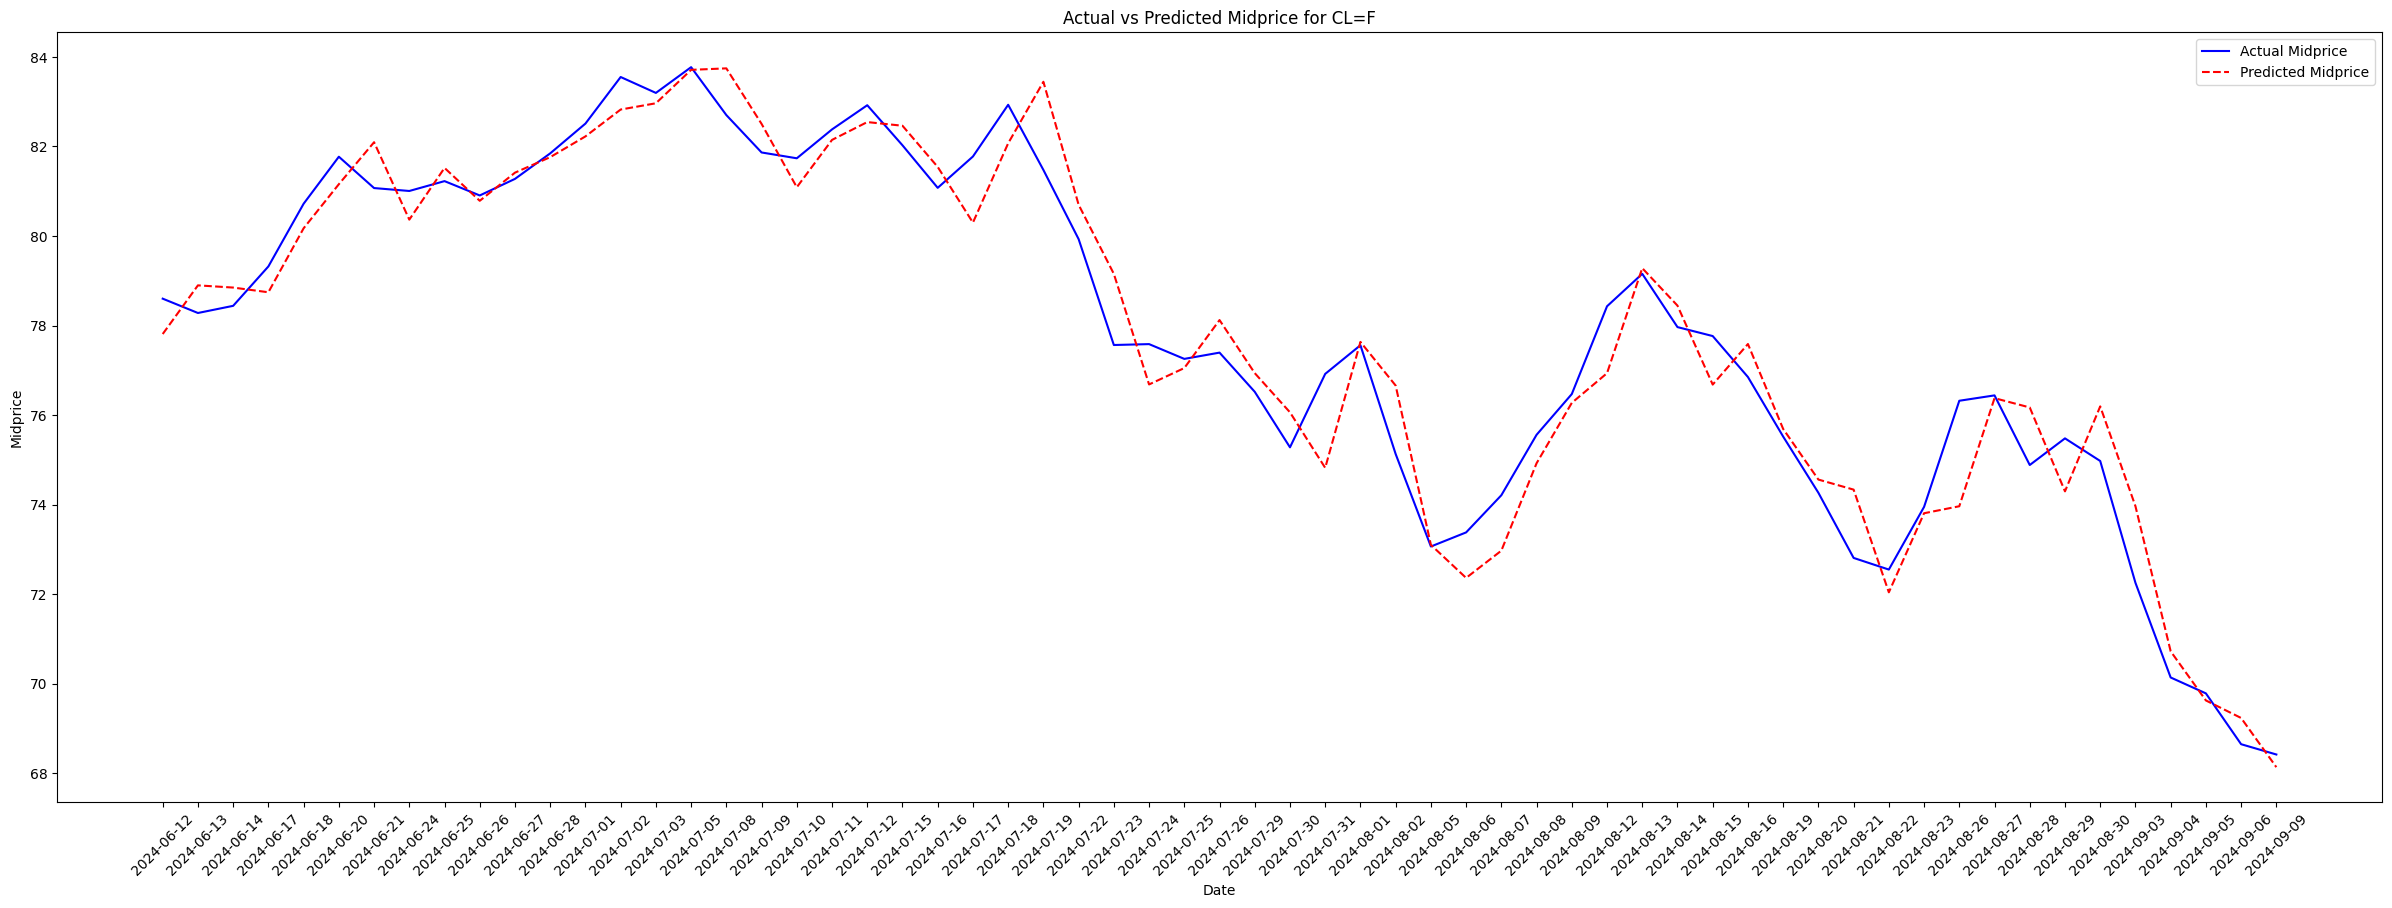

NVDA at 2024-06-10 , Actual Price: 0.75, xbregressor_result: [0.90413], xbclassifier_result: [1], final: [0.90413]
NVDA at 2024-06-11 , Actual Price: 3.919998168945313, xbregressor_result: [-0.6651292], xbclassifier_result: -1, final: [-0.6651292]
NVDA at 2024-06-12 , Actual Price: 3.7550048828125, xbregressor_result: [0.57606095], xbclassifier_result: [1], final: [0.57606095]
NVDA at 2024-06-13 , Actual Price: 2.0999984741210938, xbregressor_result: [0.9906521], xbclassifier_result: [1], final: [0.9906521]
NVDA at 2024-06-14 , Actual Price: 1.0749969482421875, xbregressor_result: [-0.02200225], xbclassifier_result: [1], final: [-0.02200225]
NVDA at 2024-06-17 , Actual Price: 1.8550033569335935, xbregressor_result: [-0.6651292], xbclassifier_result: -1, final: [-0.6651292]
NVDA at 2024-06-18 , Actual Price: 1.6299972534179688, xbregressor_result: [-0.02200225], xbclassifier_result: [1], final: [-0.02200225]
NVDA at 2024-06-20 , Actual Price: -7.674995422363281, xbregressor_result: [-0.

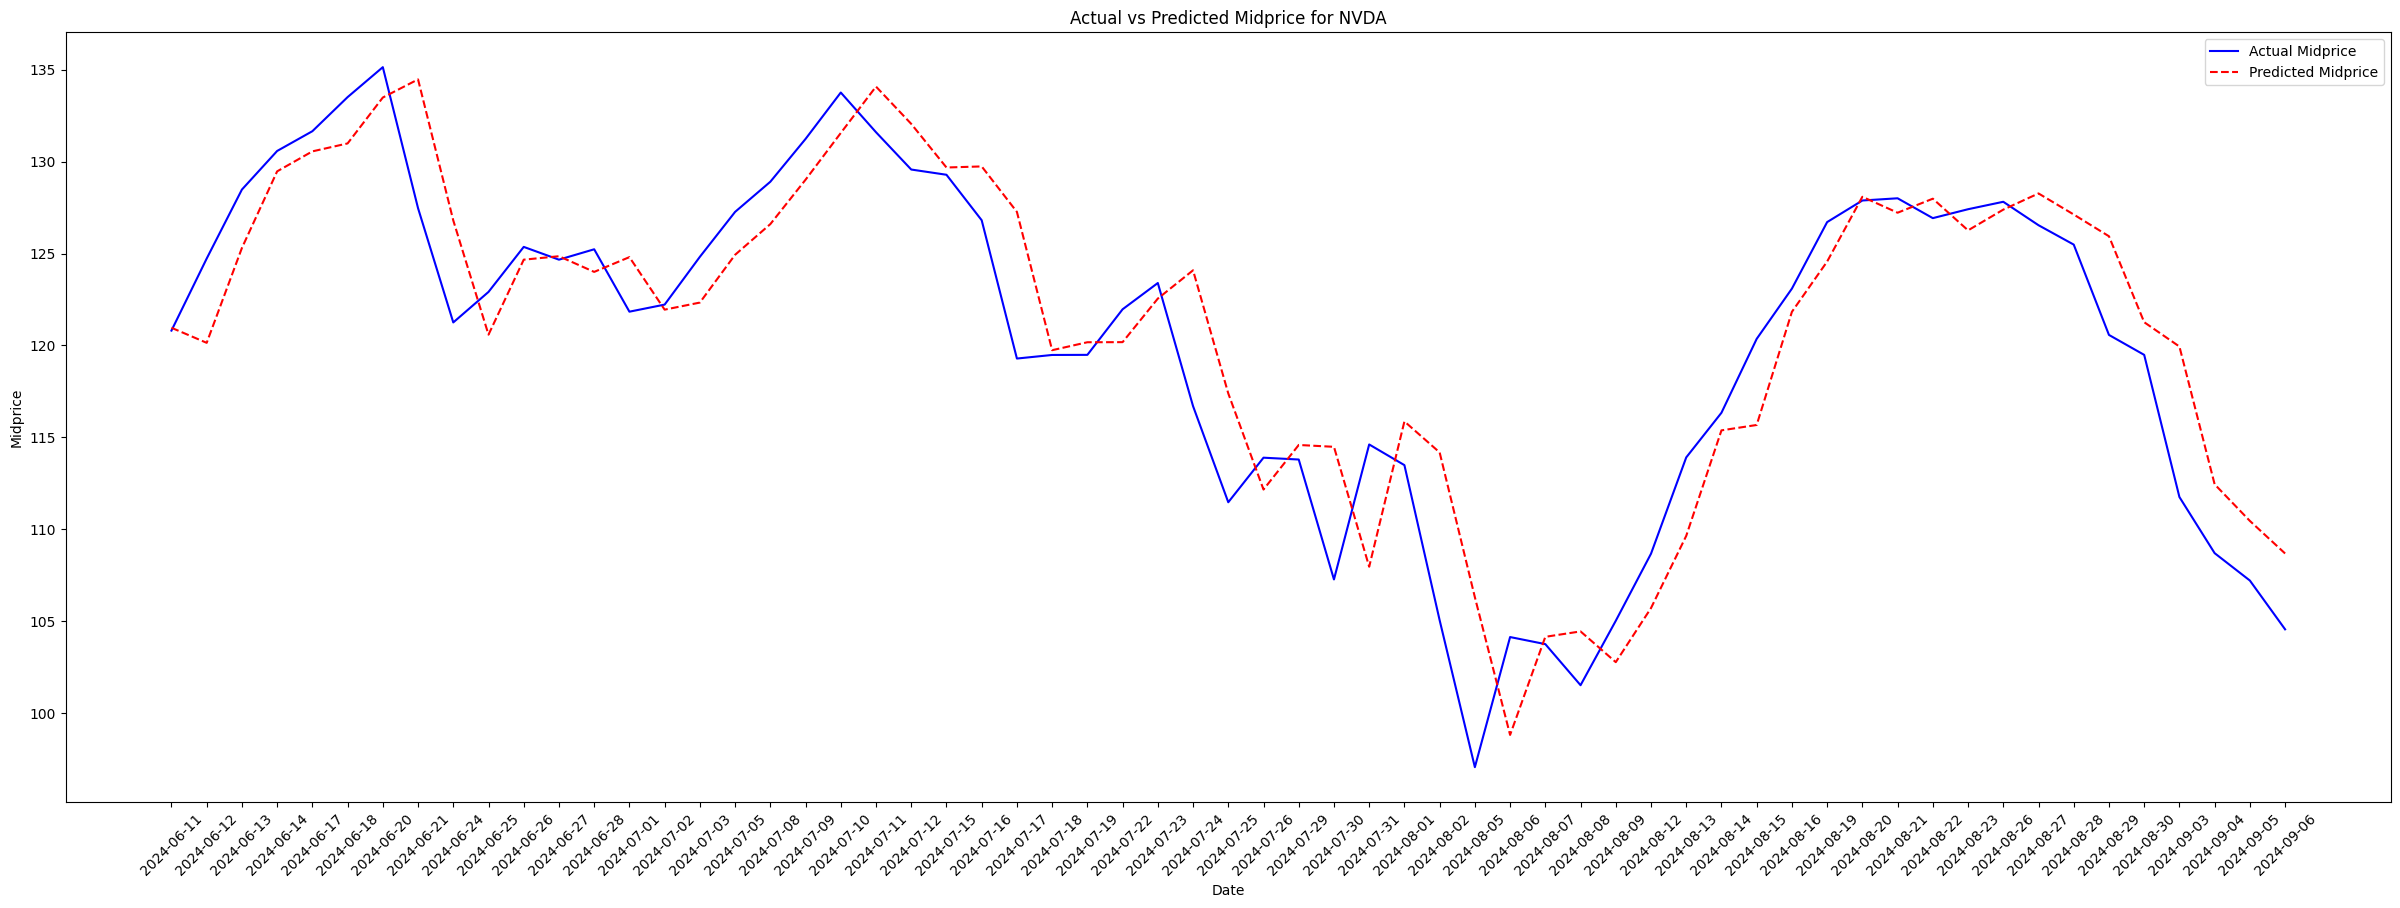

SGDUSD=X at 2024-06-11 , Actual Price: 0.0023902356624603, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1], final: [1.9640996e-05]
SGDUSD=X at 2024-06-12 , Actual Price: 0.0001456439495086, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1], final: [1.9640996e-05]
SGDUSD=X at 2024-06-13 , Actual Price: -0.0023589730262756, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1], final: [1.9640996e-05]
SGDUSD=X at 2024-06-14 , Actual Price: -7.605552673339844e-05, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1], final: [1.9640996e-05]
SGDUSD=X at 2024-06-17 , Actual Price: 1.7404556274414062e-05, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1], final: [1.9640996e-05]
SGDUSD=X at 2024-06-18 , Actual Price: 0.001173049211502, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1], final: [1.9640996e-05]
SGDUSD=X at 2024-06-19 , Actual Price: -0.0008939206600189, xbregressor_result: [1.9640996e-05], xbclassifier_result: [1],

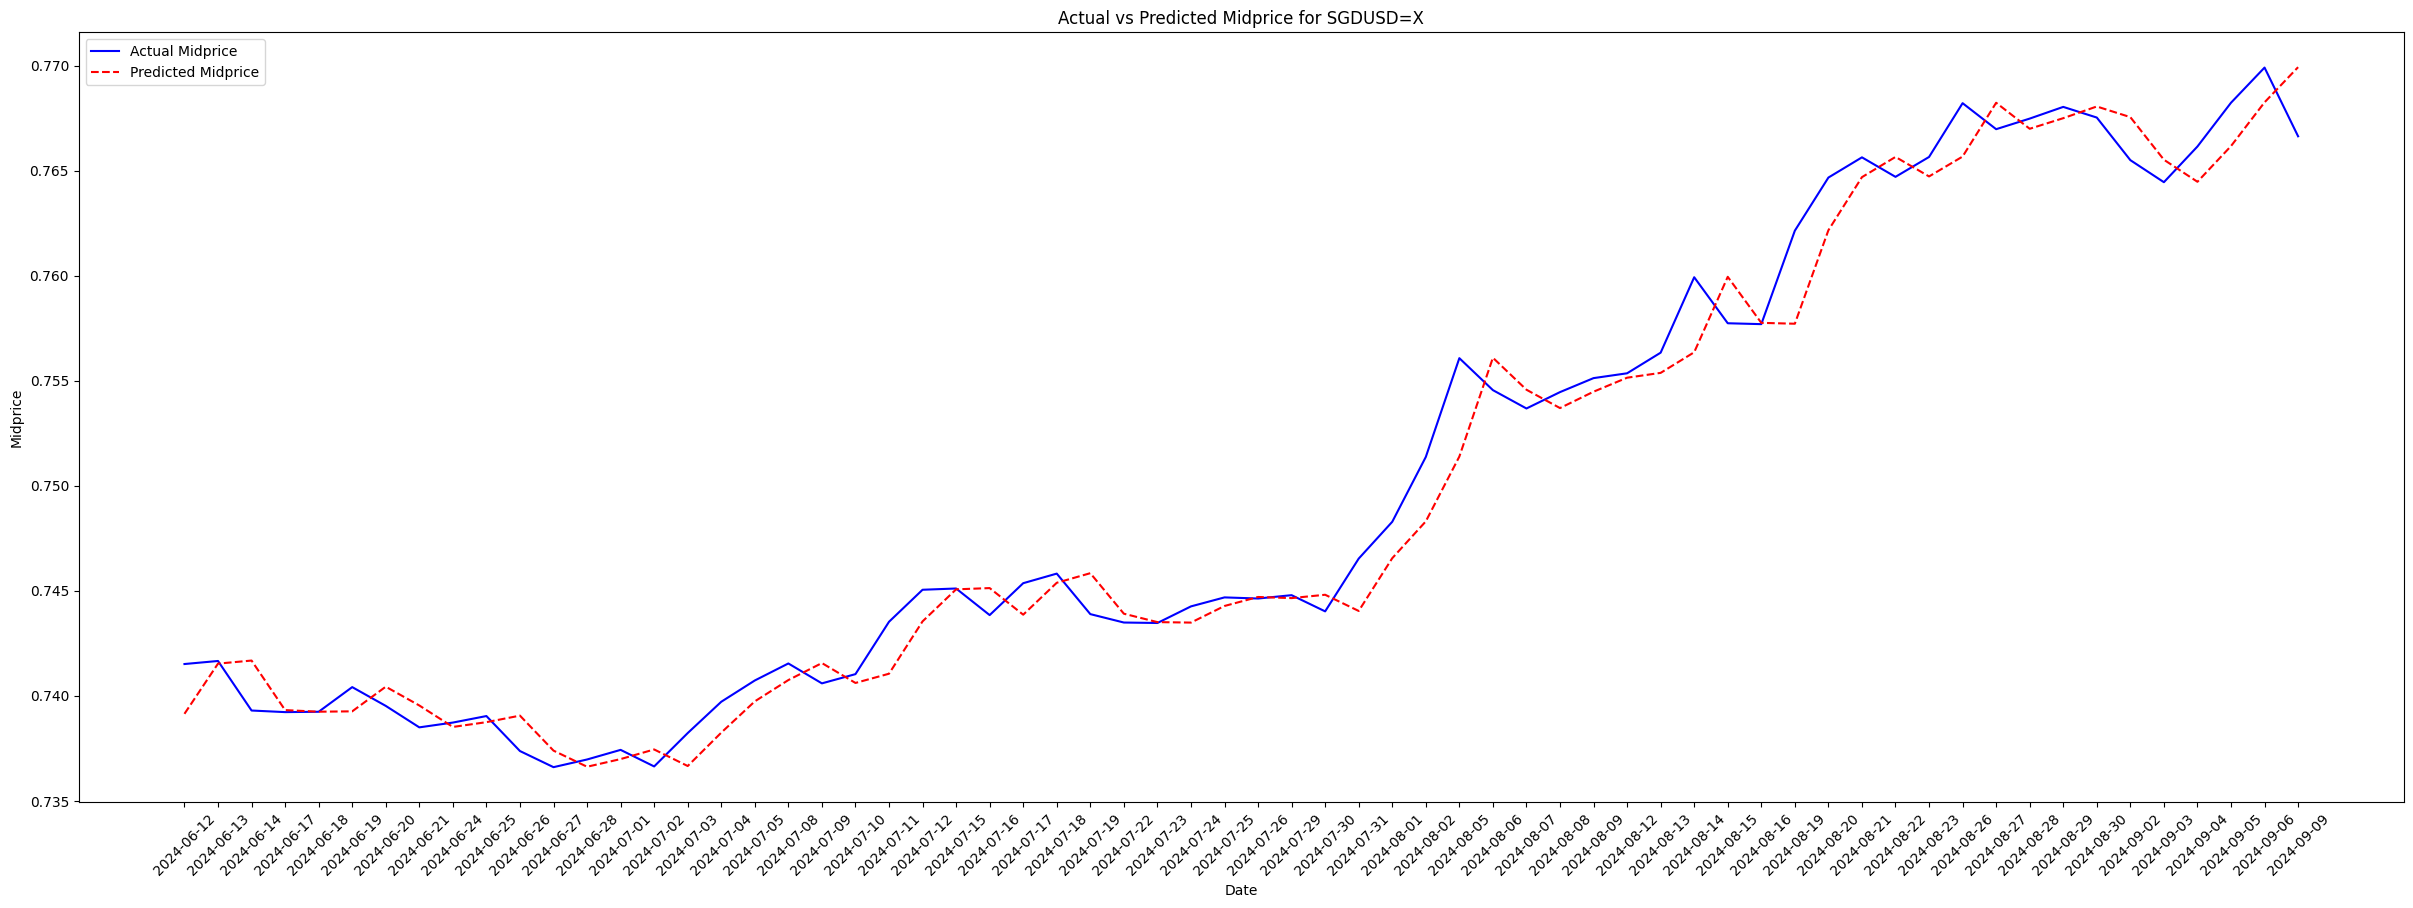

USDSGD=X at 2024-06-11 , Actual Price: -0.0043449997901916, xbregressor_result: [-3.5140212e-05], xbclassifier_result: [1], final: [-3.5140212e-05]
USDSGD=X at 2024-06-12 , Actual Price: -0.0002800226211547, xbregressor_result: [-3.5140212e-05], xbclassifier_result: [1], final: [-3.5140212e-05]
USDSGD=X at 2024-06-13 , Actual Price: 0.0043050646781921, xbregressor_result: [-3.5140212e-05], xbclassifier_result: [1], final: [-3.5140212e-05]
USDSGD=X at 2024-06-14 , Actual Price: 0.0001349449157714, xbregressor_result: [-3.5140212e-05], xbclassifier_result: -1, final: [-3.5140212e-05]
USDSGD=X at 2024-06-17 , Actual Price: -2.992153167724609e-05, xbregressor_result: [-3.5140212e-05], xbclassifier_result: -1, final: [-3.5140212e-05]
USDSGD=X at 2024-06-18 , Actual Price: -0.0021450519561767, xbregressor_result: [-3.5140212e-05], xbclassifier_result: [1], final: [-3.5140212e-05]
USDSGD=X at 2024-06-19 , Actual Price: 0.0016350150108337, xbregressor_result: [-3.5140212e-05], xbclassifier_res

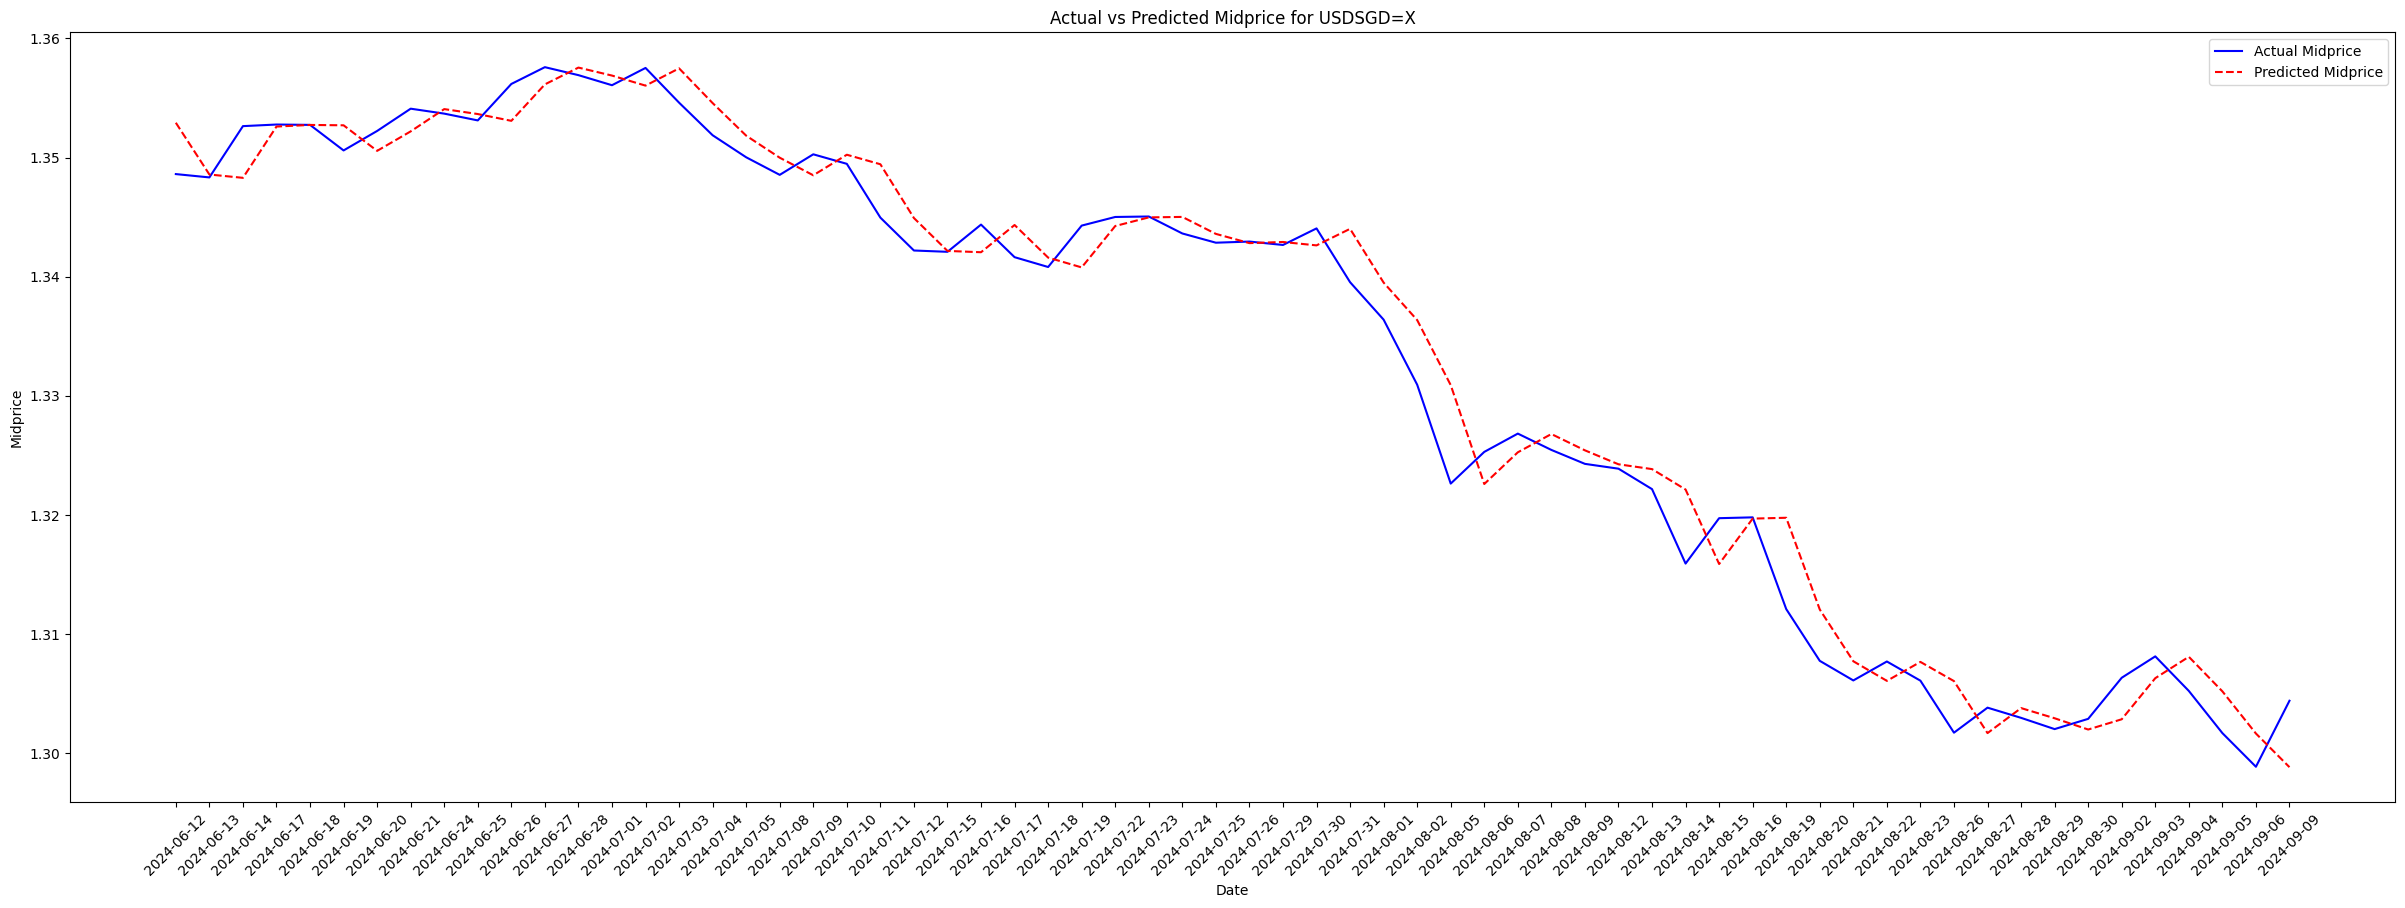

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary functions defined elsewhere:
# xbclassifier_predict, xbregressor_predict, root_mean_squared_error

for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/test/{ticker_symbol}.csv")
    X = dataframe.drop(columns=[
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ])

    sign_correct = 0
    total_predictions = 0
    actual_changes = []
    predicted_changes = []
    predicted_midprice = []

    # Loop through the dataframe starting from row 31 (index 30) to the second-to-last row
    for index, row in X.iloc[30:-1].iterrows():
        row_data = row.to_frame().T.reset_index(drop=True)  # Convert row to DataFrame and reset index
        
        xbclassifier_result = xbclassifier_predict(row_data, ticker_symbol)
        if xbclassifier_result == 0:
            xbclassifier_result = -1  # Adjust predicted_sign if it is 0
        
        xbregressor_result = xbregressor_predict(row_data, ticker_symbol)
        #predicted_value = abs(xbregressor_result) * xbclassifier_result
        predicted_value = xbregressor_result
        
        predicted_midprice.append(dataframe.iloc[index]['DAILY_MIDPRICE'] + predicted_value)

        actual_change = dataframe.iloc[index]['DAILY_MIDPRICE_CHANGE']
        actual_sign = np.sign(actual_change)
        
        # Collect actual and predicted changes for RMSE calculation
        actual_changes.append(actual_change)
        predicted_changes.append(predicted_value)

        #predicted_sign = xbclassifier_result
        predicted_sign = np.sign(xbregressor_result)
        
        # Check if the predicted sign matches the actual sign
        if predicted_sign == actual_sign:
            sign_correct += 1
        total_predictions += 1

        print(f"{ticker_symbol} at {dataframe.iloc[index]['Date']} , Actual Price: {actual_change}, xbregressor_result: {xbregressor_result}, xbclassifier_result: {xbclassifier_result}, final: {predicted_value}")

    # Calculate sign accuracy
    sign_accuracy = sign_correct / total_predictions
    print(f"{ticker_symbol} Sign Accuracy: {sign_accuracy}")

    # Calculate RMSE
    rmse = root_mean_squared_error(actual_changes, predicted_changes)
    print(f"{ticker_symbol} RMSE: {rmse}")

    # Predict the last entry
    last_row = X.iloc[-1].to_frame().T.reset_index(drop=True)
    last_xbclassifier_result = xbclassifier_predict(last_row, ticker_symbol)
    if last_xbclassifier_result == 0:
        last_xbclassifier_result = -1  # Adjust predicted_sign if it is 0
    
    last_xbregressor_result = xbregressor_predict(last_row, ticker_symbol)
    last_predicted_value = abs(last_xbregressor_result) * last_xbclassifier_result 

    print(f"{ticker_symbol} at {dataframe.iloc[-1]['Date']} , Predicted Price: {last_predicted_value}")

    # Plotting the results for each ticker
    plt.figure(figsize=(30, 10))

    # Plot actual midprice
    plt.plot(dataframe.iloc[31:]['Date'], dataframe.iloc[31:]['DAILY_MIDPRICE'], label='Actual Midprice', color='blue')

    # Plot predicted midprice
    plt.plot(dataframe.iloc[31:]['Date'], predicted_midprice, label='Predicted Midprice', color='red', linestyle='--')

    # Add title and labels
    plt.title(f'Actual vs Predicted Midprice for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Midprice')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

